In [1]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import ast
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

#### Repetim la inferència com al notebook anterior

In [2]:
model = YOLO('./runs/detect/train_5k_15e_v3/weights/best.pt')
image_root = "../../generador-tiquets/script_general/exports/data/complexity_5/coco/tickets/"
inference = model(image_root)
path = '../../generador-tiquets/script_general/exports/data/complexity_5/coco/bbx_products_in_ticket.csv'
df = pd.read_csv(path, dtype = {'ticket_id': str})
df[['b_1', 'b_2', 'b_3', 'b_4']] = df.apply(lambda row: pd.Series([ast.literal_eval(row['b_1']), ast.literal_eval(row['b_2']), ast.literal_eval(row['b_3']), ast.literal_eval(row['b_4'])]), axis=1)
data = []
# idx, per poder accedir a l'array de inferencia.
for idx, (ticket_id, grouped_df) in enumerate(df.groupby('ticket_id')):
    # Aquí tenim cada inferencia de cada tiquet:
    data_boxes = inference[idx].boxes.data

    # Ara agafem tots els bboxs que ha predit a dins de cada tiquet:
    # Convertim de tensor a numpy array
    data_boxes_np = data_boxes.cpu().detach().numpy()

    # Guardem en un dataframe amb la id del tiquet (aqui tenim un array de arrays on cada element és un bbox del tiquet "predicció")
    for bbx in data_boxes_np.tolist():
        data.append({
          'ticket_id': ticket_id,
          'x1': bbx[0],
          'y1': bbx[1],
          'x2': bbx[2],
          'y2': bbx[3],
          'acc': bbx[4],
          'label': bbx[5]
        })
predicts = pd.DataFrame(data)
predicts['label_name'] = predicts['label'].map(inference[0].names)
df['x1'] = df['b_1'].apply(lambda x: x[0])
df['y1'] = df['b_1'].apply(lambda x: x[1])
df['x2'] = df['b_4'].apply(lambda x: x[0])
df['y2'] = df['b_4'].apply(lambda x: x[1])


image 1/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000001.png: 640x384 5 descripcios, 5 quantitat_uds, 5 imports, 1 total, 2 preu_unitaris, 221.0ms
image 2/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000002.png: 640x384 5 descripcios, 5 quantitat_uds, 5 imports, 1 total, 2 preu_unitaris, 126.0ms
image 3/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000003.png: 640x352 8 descripcios, 6 quantitat_uds, 2 quantitat_kgs, 8 imports, 1 total, 5 preu_unitaris, 134.0ms
image 4/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000004.png: 640x384 4 descripcios, 3 qu

In [3]:
predicts.head()

,ticket_id,x1,y1,x2,y2,acc,label,label_name
0,000001,25.727774,309.965637,64.179657,329.858826,0.967665,1.0,quantitat_ud
1,000001,24.879581,369.811157,63.753998,389.925598,0.960742,1.0,quantitat_ud
2,000001,63.465359,369.993896,264.032379,389.880035,0.959703,0.0,descripcio
3,000001,25.191050,349.760315,63.857063,369.795715,0.959695,1.0,quantitat_ud
4,000001,306.904785,370.087677,376.022064,390.997955,0.956465,5.0,preu_unitari


In [4]:
df.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,330
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)",430.0,310,475.0,330
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",25.0,330,65.0,350
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",65.0,330,265.0,350


#### Un cop tenim la inferència feta, ja podem relacionar els dos dataframes
- Ho fem així:

#### Matriu IoU
- Per comprobar quin és el bbx que més s'apropa a cada un
- Juntament amb metode linear assignment de scipy
- Ajuntem cada bounding box amb totes les possibles opcions (bounding boxes predits), el que tingui major `IoU`, serà el que donarem com a correcte.
- ---
- IoU: https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef


In [5]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate areas of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

# Comprovació:
print(calculate_iou([0,0,2,2], (2,2,4,4)))
print(calculate_iou((0,0,2,2), (1,1,3,3)))
print(calculate_iou((0,0,2,2), (0,0,2,2)))

0.0
0.14285714285714285
1.0


In [6]:
# Calculem l'IoU de un valor real amb tots el predits.
def calculate_iou_matrix(boxes_true, boxes_pred):
    iou_matrix = np.zeros((len(boxes_true), len(boxes_pred)))
    for i, box_true in enumerate(boxes_true):
        for j, box_pred in enumerate(boxes_pred):
            iou_matrix[i, j] = calculate_iou(box_true, box_pred)
    return iou_matrix

In [7]:
boxes_pred = predicts[["x1", "y1", "x2", "y2"]].values
boxes_true = df[["x1", "y1", "x2", "y2"]].values

iou_matrix = calculate_iou_matrix(boxes_true, boxes_pred)
iou_matrix

array([[    0.95294,           0,           0, ...,     0.93645,           0,   0.0010336],
       [          0,           0,           0, ...,           0,           0,     0.97459],
       [          0,           0,           0, ...,           0,           0,           0],
       ...,
       [          0,           0,           0, ...,           0,     0.97152,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0]])

#### linear assignment de scipy

In [8]:
from scipy.optimize import linear_sum_assignment

#### Veiem a quin index correspon cada predicció

In [9]:
# Restar 1 a tota la matriu ja que el IoU com a màxim pot ser 1. Va de min=0 a max=1
# Rigurosament, hauría de ser el valor màxim que hi ha a la matriu ja que volem maximitzar el cost en comptes de minimitzar

# cost_matrix = iou_matrix.max() - iou_matrix
cost_matrix = 1 - iou_matrix

# Apply linear assignment algorithm
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

print("Optimal assignment of bounding boxes:")
print("Ground Truth Indices:", idxs_true)
print("Predicted Indices:", idxs_pred)

Optimal assignment of bounding boxes:
Ground Truth Indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150]
Predicted Indices: [ 67   9 111  12 116  10  27  20 115  14 114  19 108  63  42  32  79   8   0  26  15  85  22  73  31  84 134   7  90  36  46 110  11  39  35  74  65  75  25  76  66  72  33  21   2  55  13  29 127  43  16  56  49  58  60  44  45  59  54  41  57  53  37  52  62  47 117 150  68  78  24 143  91  92  38  48  51  81  

#### Afegim al dataframe original, les prediccions, per tenir-ho relacionat

In [10]:
predicts.head(2)

,ticket_id,x1,y1,x2,y2,acc,label,label_name
0,000001,25.727774,309.965637,64.179657,329.858826,0.967665,1.0,quantitat_ud
1,000001,24.879581,369.811157,63.753998,389.925598,0.960742,1.0,quantitat_ud


In [11]:
df.head(2)

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,330
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330


In [12]:
# Posem nom a la columna index per poder-hi accedir
df['idx'] = df.apply(lambda row: row.name, axis=1)
df.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,330,0
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330,1
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)",430.0,310,475.0,330,2
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",25.0,330,65.0,350,3
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",65.0,330,265.0,350,4


#### Posem el valor de predit al dataframe original

In [13]:
def pred_values(row, predicts, idxs_pred):
    idx_pred = idxs_pred[row.idx]
    row_pred = predicts.iloc[idx_pred]

    row['x1_pred'] = row_pred.x1
    row['y1_pred'] = row_pred.y1
    row['x2_pred'] = row_pred.x2
    row['y2_pred'] = row_pred.y2
    row['acc_pred'] = row_pred.acc
    row['label_pred'] = row_pred.label_name

    return row

df = df.apply(lambda row: pred_values(row, predicts, idxs_pred), axis=1)

df.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,330,0,25.222412,310.099579,64.155037,329.693146,0.967603,quantitat_ud
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330,1,64.721504,309.848114,264.486877,329.872040,0.947316,descripcio
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)",430.0,310,475.0,330,2,430.516418,310.148834,474.845642,329.813446,0.941037,import
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",25.0,330,65.0,350,3,25.560492,329.949554,64.124382,349.788818,0.939450,quantitat_ud
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",65.0,330,265.0,350,4,64.104164,329.893341,265.951294,350.118927,0.931638,descripcio


#### Mirem quantes etiquetes són iguals

In [14]:
df['label_correct'] = df['etiqueta'] == df['label_pred']
df.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,330,0,25.222412,310.099579,64.155037,329.693146,0.967603,quantitat_ud,True
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330,1,64.721504,309.848114,264.486877,329.872040,0.947316,descripcio,True
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)",430.0,310,475.0,330,2,430.516418,310.148834,474.845642,329.813446,0.941037,import,True
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",25.0,330,65.0,350,3,25.560492,329.949554,64.124382,349.788818,0.939450,quantitat_ud,True
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",65.0,330,265.0,350,4,64.104164,329.893341,265.951294,350.118927,0.931638,descripcio,True


In [15]:
correctes = df['label_correct'].sum()
total = len(df)

correctes, total

(151, 151)

#### Percentatge d'encert:
- No tenim amb compte si ha encertat els bounding box o no. Només la etiqueta per fer-nos una idea.

In [16]:
(correctes / total) * 100

100.0

#### Confusion Matrix

In [17]:
sns.set_theme(context = 'notebook', style = "white", font_scale = 1.0)

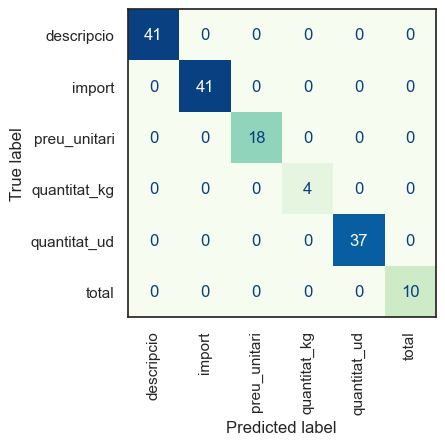

In [18]:
_, axs = plt.subplots(1, 1, figsize = (4, 4))
ConfusionMatrixDisplay.from_predictions(
    df.etiqueta,
    df.label_pred,
    ax = axs,
    colorbar = False,
    cmap = 'GnBu',
    xticks_rotation=90
);

- Abans:
- Al igual que amb les descripcions i els preus €/kg, que sortien malament, ara pasa el mateix amb l'import i el total. Provarem de fer el bbx del total més gran ja que pot ser un número major i així, al tenir un bbx diferent al de import, esperem que millori.

#### Està explicat a la memòria amb les execucions i resultats anteriors.

#### Mirem la quantitat de productes que tenien els que ha fet bé i els que ha fet malament.
- suposem que els que estàn bé, són els tiquets més llargs que per tant tenen el bbox del tota més avall i per tant la xarxa no es pot confondre tant amb el el bbx del import i els que ha fet malament tenen menys productes (són més curts).
- Ara surten tots bé, però les execucions anteriors etàn a la mamòria amb captures.

In [19]:
df_import_and_total = df[(df['etiqueta'] == 'total')]

df_wrong = df_import_and_total[df_import_and_total['label_correct'] == False]
df_correct = df_import_and_total[df_import_and_total['label_correct'] == True]

df_wrong.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct


In [20]:
len(df_wrong)

0

#### Productes que hi ha en els tiquets que la etiqueta import i total ha sigut ben diferenciada:
- Per saber el total de productes, sumem totes les descripcions que hi ha en el df original.
- Agrupem el df original per ticket_id (on hi ha tots els registres de tots els tiquets per separat `df`).
- Si el ticket_id està en la llista dels tiquets correctes, sumem tots els productes que hi havia en aquell tiquet.

In [21]:
# No ho fem amb dict comprehension per no sobrecomplicar la sintaxis.
total_productes_tickets = []
for ticket_id, grouped_df in df.groupby('ticket_id'):
    if ticket_id in df_correct.ticket_id.unique():
        total_productes_tickets.append({
            "ticket_id" : ticket_id,
            "products": grouped_df['etiqueta'].value_counts()['descripcio']
        })

# Mirem quants quants cops tenim 'x' productes:
count = {}

for n_productes in total_productes_tickets:
    total = n_productes['products']
    if total in count:
        count[total] += 1
    else:
        count[total] = 1

ordenat = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))


# Imprimir el recuento de cada cantidad de productos
for qty, cops in ordenat.items():
    print(f"Número de productes: {qty}, Surt: {cops}")

Número de productes: 5, Surt: 2
Número de productes: 4, Surt: 2
Número de productes: 3, Surt: 2
Número de productes: 8, Surt: 1
Número de productes: 2, Surt: 1
Número de productes: 6, Surt: 1
Número de productes: 1, Surt: 1


#### Veiem com si que la majoría que estàn bé, tenen més productes.
#### Ara mirem els que estan malament i hauría de ser al revés.

In [22]:
total_productes_tickets = []
for ticket_id, grouped_df in df.groupby('ticket_id'):
    if ticket_id in df_wrong.ticket_id.unique():
        total_productes_tickets.append({
            "ticket_id" : ticket_id,
            "products": grouped_df['etiqueta'].value_counts()['descripcio']
        })
# Mirem quants quants cops tenim 'x' productes:
count = {}

for n_productes in total_productes_tickets:
    total = n_productes['products']
    if total in count:
        count[total] += 1
    else:
        count[total] = 1

ordenat = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))


# Imprimir el recuento de cada cantidad de productos
for qty, cops in ordenat.items():
    print(f"Número de productes: {qty}, Surt: {cops}")

#### Examinació dels bounding box.
#### Pintem el real i la predicció per veure com de bé s'ha fet:

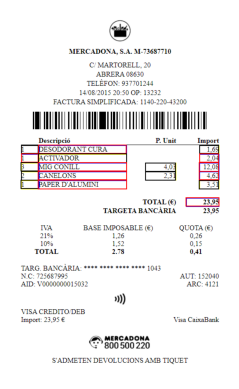

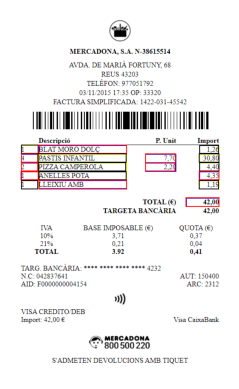

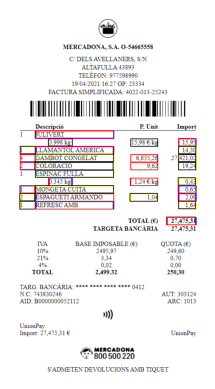

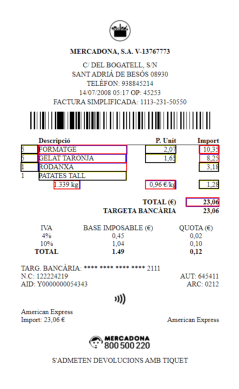

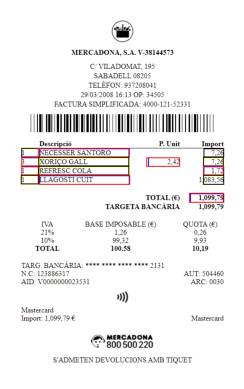

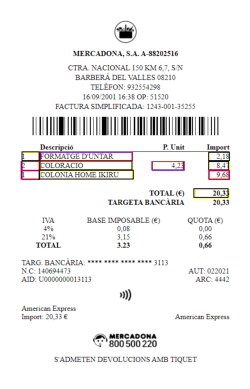

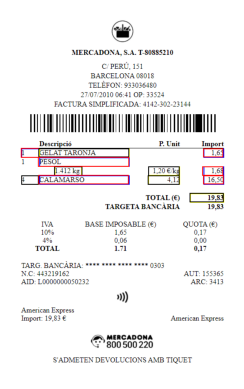

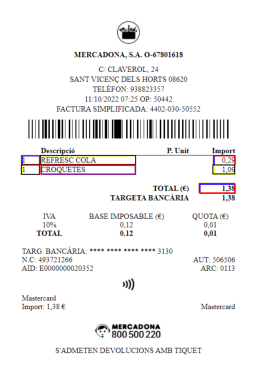

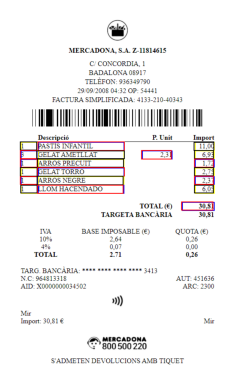

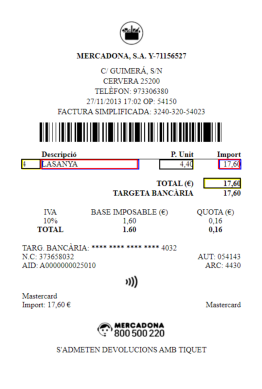

In [23]:
image_root = "../../generador-tiquets/script_general/exports/data/complexity_5/coco/tickets/"

colors = {
    0: { 1 :'red', 2 :'blue' },
    1: { 1 :'black', 2 :'yellow' },
}

for ticket_id, grouped_df in df.groupby('ticket_id'):
    pilImg = Image.open(f"{image_root}{ticket_id}.png")
    imgdrw = ImageDraw.Draw(pilImg)

    for idx, item in grouped_df.iterrows():
        color_key = idx % 2 == 0

        imgdrw.rectangle([(item.x1, item.y1),(item.x2, item.y2)], outline = colors[color_key][2], width = 2)
        imgdrw.rectangle([(item.x1_pred, item.y1_pred),(item.x2_pred, item.y2_pred)], outline = colors[color_key][1], width = 2)

    plt.imshow(pilImg)
    plt.axis('off');
    plt.show()

    if ticket_id == '000010':
        break

#### IoU i mAP
- Ja hem vist que dona tots bé així que el mAP per rellevància, però l'hem estat investigant també.
- mAP per un llindar IoU >= 75
    - https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
    - https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/

- Altres:
    - https://abhishri-medewar.medium.com/mean-average-precision-map-in-object-detection-78900922b3f0
    - https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

In [24]:
# calcular el mAP (p.ex. per un llindar IoU>= 75)
def calculate_iou_for(row):
    box_1 = [row.x1, row.y1, row.x2, row.y2]
    box_2 = [row.x1_pred, row.y1_pred, row.x2_pred, row.y2_pred]
    return calculate_iou(box_1, box_2)

df['IoU'] = df.apply(lambda row: calculate_iou_for(row), axis=1)
df.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct,IoU
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,330,0,25.222412,310.099579,64.155037,329.693146,0.967603,quantitat_ud,True,0.953536
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330,1,64.721504,309.848114,264.486877,329.872040,0.947316,descripcio,True,0.982243
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)",430.0,310,475.0,330,2,430.516418,310.148834,474.845642,329.813446,0.941037,import,True,0.968574
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",25.0,330,65.0,350,3,25.560492,329.949554,64.124382,349.788818,0.939450,quantitat_ud,True,0.951603
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",65.0,330,265.0,350,4,64.104164,329.893341,265.951294,350.118927,0.931638,descripcio,True,0.979797


#### Examinem els resultats del IoU

In [25]:
df.describe().IoU

count    151.000000
mean       0.949881
std        0.026914
min        0.872932
25%        0.930912
50%        0.955976
75%        0.970913
max        0.986314
Name: IoU, dtype: float64

In [26]:
df['IoU'].sort_values()

129    0.872932
146    0.875806
125    0.888368
126    0.889679
119    0.893032
         ...   
9      0.984190
52     0.984329
68     0.984358
11     0.985183
59     0.986314
Name: IoU, Length: 151, dtype: float64

In [27]:
worst = df.loc[df['IoU'].idxmin()]
second_worst = df['IoU'].sort_values().index[1]
third_worst = df['IoU'].sort_values().index[2]

second_worst = df.iloc[second_worst]
third_worst = df.iloc[third_worst]

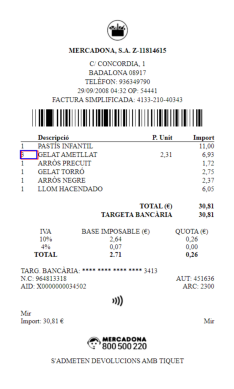

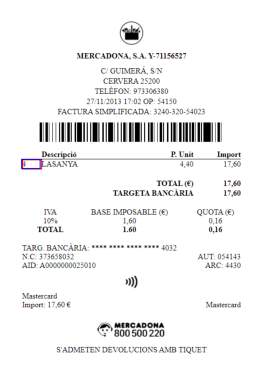

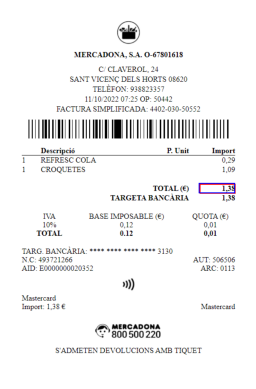

In [28]:
for item in [worst, second_worst, third_worst]:
    pilImg = Image.open(f"{image_root}{item.ticket_id}.png")
    imgdrw = ImageDraw.Draw(pilImg)

    imgdrw.rectangle([(item.x1, item.y1),(item.x2, item.y2)], outline = 'red', width = 2)
    imgdrw.rectangle([(item.x1_pred, item.y1_pred),(item.x2_pred, item.y2_pred)], outline = 'blue', width = 2)

    plt.imshow(pilImg)
    plt.axis('off');
    plt.show()

#### Calculate TP, FP, FN for a given threshold `thr`:

In [29]:
def assign_label(row, thr):
    if row['IoU'] > thr:
        if row['label_pred'] == row['etiqueta']:
            return 'TP'
        else:
            return 'FN' # Això no sería FP (False Positiu) ???
    else:
        if row['IoU'] != 0:
            return 'FP' # Això no sería FN (Fals negatiu) ???
        else:
            return 'FN' # Fer comprovacions i mirar si és FP (False Positive)

thr = 0.75
df['label'] = df.apply(lambda row: assign_label(row, thr), axis=1)

total_fp = df['label'].eq('FP').sum()
total_tp = df['label'].eq('TP').sum()
total_fn = df['label'].eq('FN').sum()

df.head(5)

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,...,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct,IoU,label
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,...,0,25.222412,310.099579,64.155037,329.693146,0.967603,quantitat_ud,True,0.953536,TP
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,...,1,64.721504,309.848114,264.486877,329.872040,0.947316,descripcio,True,0.982243,TP
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)",430.0,310,475.0,...,2,430.516418,310.148834,474.845642,329.813446,0.941037,import,True,0.968574,TP
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",25.0,330,65.0,...,3,25.560492,329.949554,64.124382,349.788818,0.939450,quantitat_ud,True,0.951603,TP
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",65.0,330,265.0,...,4,64.104164,329.893341,265.951294,350.118927,0.931638,descripcio,True,0.979797,TP


In [30]:
print(f"TP: {total_tp}\nFP: {total_fp}\nFN: {total_fn}")

TP: 151
FP: 0
FN: 0


#### Renombrem per calcular presicion i recall

In [31]:
df['label'] = df.apply(lambda row: 'TP' if row.label == 'TP' else 'FP', axis=1)
df.label.unique()

array(['TP'], dtype=object)

#### Presicion and Recall
- Ordenar segons la predicció de més a menys

In [32]:
df_sorted = df.sort_values(by='acc_pred', ascending=False)
df_sorted.head(5)

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,...,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct,IoU,label
145,000009,total,"30,81","(400, 450)","(475, 450)","(400, 470)","(475, 470)",400.0,450,475.0,...,145,398.589447,449.421204,472.057556,469.854156,0.975127,total,True,0.910930,TP
82,000005,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,...,82,25.537903,309.999084,63.857124,329.717163,0.972694,quantitat_ud,True,0.944392,TP
40,000003,quantitat_ud,1,"(25, 350)","(65, 350)","(25, 370)","(65, 370)",25.0,350,65.0,...,40,25.323490,349.703400,64.009750,369.938171,0.968891,quantitat_ud,True,0.950533,TP
150,000010,total,"17,60","(400, 350)","(475, 350)","(400, 370)","(475, 370)",400.0,350,475.0,...,150,398.228027,348.862640,474.247009,369.712006,0.968663,total,True,0.902656,TP
11,000001,descripcio,CANELONS,"(65, 370)","(265, 370)","(65, 390)","(265, 390)",65.0,370,265.0,...,11,63.705700,369.969910,265.414154,389.901031,0.968224,descripcio,True,0.985183,TP


#### Afegir els acomultats de TP i FP
- `cumsum()`: suma acomulativa &rarr; nou array on els valors són la suma dels anteriors. Ex:
    - original: [1,2,3,4,5]
    - output: [1,3,6,10,15]
        - 1: 1
        - 3: 2 +1
        - 6: 1 +2 +3
        - ···

In [33]:
df_sorted['Acc_TP'] = (df_sorted['label'] == 'TP').cumsum()
df_sorted['Acc_FP'] = (df_sorted['label'] == 'FP').cumsum()
df_sorted.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,...,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct,IoU,label,Acc_TP,Acc_FP
145,000009,total,"30,81","(400, 450)","(475, 450)","(400, 470)","(475, 470)",400.0,450,475.0,...,449.421204,472.057556,469.854156,0.975127,total,True,0.910930,TP,1,0
82,000005,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,...,309.999084,63.857124,329.717163,0.972694,quantitat_ud,True,0.944392,TP,2,0
40,000003,quantitat_ud,1,"(25, 350)","(65, 350)","(25, 370)","(65, 370)",25.0,350,65.0,...,349.703400,64.009750,369.938171,0.968891,quantitat_ud,True,0.950533,TP,3,0
150,000010,total,"17,60","(400, 350)","(475, 350)","(400, 370)","(475, 370)",400.0,350,475.0,...,348.862640,474.247009,369.712006,0.968663,total,True,0.902656,TP,4,0
11,000001,descripcio,CANELONS,"(65, 370)","(265, 370)","(65, 390)","(265, 390)",65.0,370,265.0,...,369.969910,265.414154,389.901031,0.968224,descripcio,True,0.985183,TP,5,0


- $P=\frac{TP}{TP+FP}$
- <br/>
- $R=\frac{TP}{nºmostres}$

In [34]:
df_sorted['Precision'] = df_sorted['Acc_TP'] / (df_sorted['Acc_TP'] + df_sorted['Acc_FP'])
df_sorted['Recall'] = df_sorted['Acc_TP'] / len(df_sorted)

df_sorted

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,...,y2_pred,acc_pred,label_pred,label_correct,IoU,label,Acc_TP,Acc_FP,Precision,Recall
145,000009,total,"30,81","(400, 450)","(475, 450)","(400, 470)","(475, 470)",400.0,450,475.0,...,469.854156,0.975127,total,True,0.910930,TP,1,0,1.0,0.006623
82,000005,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,...,329.717163,0.972694,quantitat_ud,True,0.944392,TP,2,0,1.0,0.013245
40,000003,quantitat_ud,1,"(25, 350)","(65, 350)","(25, 370)","(65, 370)",25.0,350,65.0,...,369.938171,0.968891,quantitat_ud,True,0.950533,TP,3,0,1.0,0.019868
150,000010,total,"17,60","(400, 350)","(475, 350)","(400, 370)","(475, 370)",400.0,350,475.0,...,369.712006,0.968663,total,True,0.902656,TP,4,0,1.0,0.026490
11,000001,descripcio,CANELONS,"(65, 370)","(265, 370)","(65, 390)","(265, 390)",65.0,370,265.0,...,389.901031,0.968224,descripcio,True,0.985183,TP,5,0,1.0,0.033113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,000001,import,"4,62","(430, 370)","(475, 370)","(430, 390)","(475, 390)",430.0,370,475.0,...,389.936005,0.905834,import,True,0.977116,TP,147,0,1.0,0.973510
80,000004,import,"1,28","(430, 390)","(475, 390)","(430, 410)","(475, 410)",430.0,390,475.0,...,409.626526,0.900238,import,True,0.938289,TP,148,0,1.0,0.980132
77,000004,quantitat_kg,1.339,"(99, 390)","(159, 390)","(99, 410)","(159, 410)",99.0,390,159.0,...,410.279297,0.880421,quantitat_kg,True,0.955007,TP,149,0,1.0,0.986755
36,000003,quantitat_kg,0.998,"(99, 330)","(159, 330)","(99, 350)","(159, 350)",99.0,330,159.0,...,349.885376,0.866024,quantitat_kg,True,0.956725,TP,150,0,1.0,0.993377


#### Mostrem la presicion Vs Recall

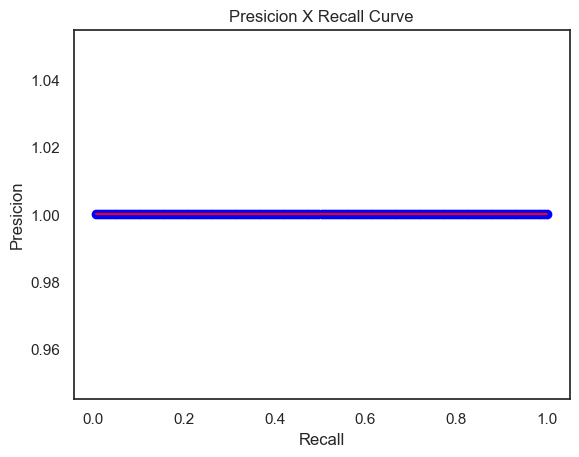

In [35]:
plt.scatter(df_sorted['Recall'], df_sorted['Precision'], color='blue')
plt.plot(df_sorted['Recall'], df_sorted['Precision'], color='red')

plt.xlabel('Recall')
plt.ylabel('Presicion')
plt.title('Presicion X Recall Curve')

plt.show()

#### Calcular AP
- És l'area interpolada per cada classe
- Fer-ho per diferents threshold
- Després fer-ne la mitjana-ne la mitjana per tenir mAP
- ---
- Ho fem amb python.
  - https://www.linkedin.com/pulse/map-calculation-object-detection-code-amara-dinesh-kumar
  - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html:

In [36]:
y_true = df['label_correct']
y_scores = df['IoU']

In [37]:
from sklearn.metrics import average_precision_score

# y_true and y_scores are the ground truth labels and prediction scores respectively
average_precision = average_precision_score(y_true, y_scores)
print("mAP: ", average_precision)

mAP:  1.0


#### Ho provem per diferents threshold `thr`

In [38]:
thrs = np.arange(0.60, 1.00, 0.05)
thrs

array([        0.6,        0.65,         0.7,        0.75,         0.8,        0.85,         0.9,        0.95])

In [39]:
y_true = df['label_correct']
y_scores = df.apply(lambda row: calculate_iou_for(row), axis=1)

average_precision = average_precision_score(y_true, y_scores)
print("mAP: ", average_precision)

mAP:  1.0
